In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data( )

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
y_train.shape

(60000,)

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
y_train[0]

5

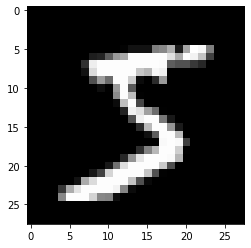

In [7]:
imagendemo=x_train[0]
plt.imshow(imagendemo,cmap='gray')

In [8]:
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

y_train_onehot.shape

(60000, 10)

# Declarando la arquitectura


In [0]:
class DNN_model(object):
  def __init__(self,
               n_classes=10):
    self.C1LW = tf.Variable(np.random.rand(5,5,1,32),name="hl1weigths",dtype="float32")
    self.C1LB = tf.Variable(np.random.rand(32),name="hl1bias",dtype="float32")
    self.C2LW = tf.Variable(np.random.rand(5,5,32,64),name="hl2weigths",dtype="float32")
    self.C2LB = tf.Variable(np.random.rand(64),name="hl2bias",dtype="float32")
    self.D1LW = tf.Variable(np.random.rand(5,5,32,64),name="hl1weigths",dtype="float32")
    self.D1LB = tf.Variable(np.random.rand(32),name="hl1bias",dtype="float32")
    self.D2LW = tf.Variable(np.random.rand(5,5,1,32),name="hl2weigths",dtype="float32")
    self.D2LB = tf.Variable(np.random.rand(1),name="hl2bias",dtype="float32")
    self.trainable_variables =[self.C1LW,self.C1LB,self.C2LW,self.C2LB,self.D1LW,self.D1LB,self.D2LW,self.D2LB]          
  def __call__(self,x,Batch): 

      # Declarando la arquitectura
      x  = tf.cast(x, tf.float32)
      img = tf.reshape(x, shape=[-1, 28, 28, 1])

      C1= tf.nn.conv2d(img,self.C1LW, strides=[1,2,2,1], padding='SAME')  
      C1 = tf.add(C1, self.C1LB)
      C1 = tf.nn.relu(C1)
      #14*14*32

      C2= tf.nn.conv2d(C1,self.C2LW, strides=[1,2,2,1], padding='SAME')  
      C2 = tf.add(C2, self.C2LB)
      C2 = tf.nn.relu(C2)
      #7*7*64
      
      D1= tf.nn.conv2d_transpose(C2,self.D1LW, tf.constant([Batch,14,14,32]),strides=[1,2,2,1],padding='SAME')  
      D1 = tf.add(D1, self.D1LB)
      D1 = tf.nn.relu(D1)
      #imagen resultante de 14x14x32
      D2= tf.nn.conv2d_transpose(D1,self.D2LW, tf.constant([Batch,28,28,1]),strides=[1,2,2,1],padding='SAME')  
      D2 = tf.add(D2, self.D2LB)
      D2 = tf.nn.relu(D2)
      #imagen resultante de 28x28x1

      
      return D2
  

In [54]:
DNN = DNN_model()
DNN(x_train[24:30],6)

<tf.Tensor: shape=(6, 28, 28, 1), dtype=float32, numpy=
array([[[[6.69822031e+04],
         [1.90612188e+06],
         [2.16190350e+06],
         ...,
         [1.18249008e+08],
         [1.58319230e+07],
         [1.73416900e+07]],

        [[7.43573900e+06],
         [5.12126600e+07],
         [5.87481320e+07],
         ...,
         [3.87830144e+08],
         [5.72875040e+07],
         [5.63109280e+07]],

        [[8.11829800e+06],
         [5.47801880e+07],
         [6.09144680e+07],
         ...,
         [4.05377472e+08],
         [5.33489120e+07],
         [5.71193920e+07]],

        ...,

        [[1.37194656e+08],
         [6.67756288e+08],
         [6.72148416e+08],
         ...,
         [7.37392512e+08],
         [2.53317312e+08],
         [2.67334928e+08]],

        [[7.43455680e+07],
         [3.33959488e+08],
         [3.41877056e+08],
         ...,
         [2.98522336e+08],
         [1.05901760e+08],
         [1.11523168e+08]],

        [[7.29121760e+07],
         [3.4

In [0]:
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')


test_loss = tf.keras.metrics.Mean(name='test_loss')


In [0]:
@tf.function
def train_step(model,tdata, labels):
  with tf.GradientTape() as tape:
    predictions = model(tdata,len(tdata))
    #calculo de una funcion de error 
    x = tf.cast(labels, tf.float32)
    img = tf.reshape(x, shape=[-1, 28, 28, 1])
    loss = tf.reduce_mean(tf.math.squared_difference(img, predictions))
   
  gradients = tape.gradient(loss, model.trainable_variables)
  capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
  optimizador.apply_gradients(capped_grads_and_vars)
  train_loss(loss)


In [0]:
@tf.function
def test_step(model,tdata, labels):
  predictions = model(tdata,len(tdata))
  x = tf.cast(labels, tf.float32)
  img = tf.reshape(x, shape=[-1, 28, 28, 1])
  t_loss = tf.reduce_mean(tf.math.squared_difference(img, predictions))

  test_loss(t_loss)


In [0]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
  for epoch in range(EPOCHS):
    i=0
    while i+batch_size < len(train_x) or i+batch_size<batch_size*N_batch:
      start = i
      end = i+batch_size
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
      train_step(model,batch_x,batch_y)
      i+=batch_size

    test_step(model,test_x,test_y)
      
    template = 'Epoch {}, Perdida: {},  Perdida de prueba: {}'
    print(template.format(epoch+1,train_loss.result(),test_loss.result()))
    
    train_loss.reset_states()
    
    test_loss.reset_states()
    

  

In [68]:
fitting(DNN,x_train,x_train,x_test,x_test,20,600,100)

Epoch 1, Perdida: 9.785559856919347e+16,  Perdida de prueba: 1391206076514304.0
Epoch 2, Perdida: 293428608892928.0,  Perdida de prueba: 177815068606464.0
Epoch 3, Perdida: 116357702090752.0,  Perdida de prueba: 77809506582528.0
Epoch 4, Perdida: 53185381138432.0,  Perdida de prueba: 37049172230144.0
Epoch 5, Perdida: 25710487928832.0,  Perdida de prueba: 18067471990784.0
Epoch 6, Perdida: 12497177280512.0,  Perdida de prueba: 8688088645632.0
Epoch 7, Perdida: 5895223246848.0,  Perdida de prueba: 3960554913792.0
Epoch 8, Perdida: 2601398566912.0,  Perdida de prueba: 1669974851584.0
Epoch 9, Perdida: 1052632875008.0,  Perdida de prueba: 633231179776.0
Epoch 10, Perdida: 380802007040.0,  Perdida de prueba: 215708581888.0
Epoch 11, Perdida: 128028909568.0,  Perdida de prueba: 73365995520.0
Epoch 12, Perdida: 46714728448.0,  Perdida de prueba: 30415161344.0
Epoch 13, Perdida: 21685696512.0,  Perdida de prueba: 16081191936.0
Epoch 14, Perdida: 12363943936.0,  Perdida de prueba: 9857685504.0